## Optimization model 

In [1]:
from model import shortestPathModel

In [2]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-04-13
Using license file C:\Users\Apocrypse\gurobi.lic


In [3]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print('Obj: {}'.format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [4]:
from data import shortestpath, dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [5]:
# generate data for grid network (features and costs)
n = 1000
p = 5
x, c = shortestpath.genData(n, p, grid)

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, random_state=246)

In [7]:
# get training data set
sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)

Optimizing...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 354.25it/s]


In [8]:
# get training data set
sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)

Optimizing...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 347.23it/s]


In [9]:
# get data loader
sp_loader_train = DataLoader(sp_dataset_train, batch_size=32, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=32, shuffle=False)

In [10]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 5])

In [12]:
c.shape

torch.Size([32, 40])

In [13]:
w.shape

torch.Size([32, 40])

In [14]:
z.shape

torch.Size([32, 1])

## Loss Function

In [15]:
from loss import SPOPlusLoss

In [16]:
# init SPO+ loss
criterion = SPOPlusLoss()

## Linear Regression 

In [17]:
import torch
from torch import nn

In [18]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [19]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

## Training 

In [20]:
from matplotlib import pyplot as plt

In [21]:
# set optimizer
optimizer = torch.optim.SGD(lr.parameters(), lr=1e-2)

In [22]:
# train model
num_epochs = 200
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = lr(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if epoch % 1 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch, loss.item()))

epoch 0, loss:7.788824
epoch 1, loss:9.252686
epoch 2, loss:8.455514
epoch 3, loss:7.327313
epoch 4, loss:6.946222
epoch 5, loss:6.527593
epoch 6, loss:7.623812
epoch 7, loss:6.176763
epoch 8, loss:6.631300
epoch 9, loss:6.094060
epoch 10, loss:6.466005
epoch 11, loss:5.701963
epoch 12, loss:5.838727
epoch 13, loss:7.094440
epoch 14, loss:6.417104
epoch 15, loss:5.122665
epoch 16, loss:5.361857
epoch 17, loss:6.055743
epoch 18, loss:4.610134
epoch 19, loss:6.512327
epoch 20, loss:4.740639
epoch 21, loss:4.647330
epoch 22, loss:5.951818
epoch 23, loss:4.279677
epoch 24, loss:3.571465
epoch 25, loss:4.640172
epoch 26, loss:3.934464
epoch 27, loss:4.463154
epoch 28, loss:3.473514
epoch 29, loss:3.943493
epoch 30, loss:4.441861
epoch 31, loss:3.330313
epoch 32, loss:4.277127
epoch 33, loss:3.876950
epoch 34, loss:3.593291
epoch 35, loss:3.476929
epoch 36, loss:3.259997
epoch 37, loss:2.819826
epoch 38, loss:3.747567
epoch 39, loss:2.932236
epoch 40, loss:3.061008
epoch 41, loss:2.398223
ep

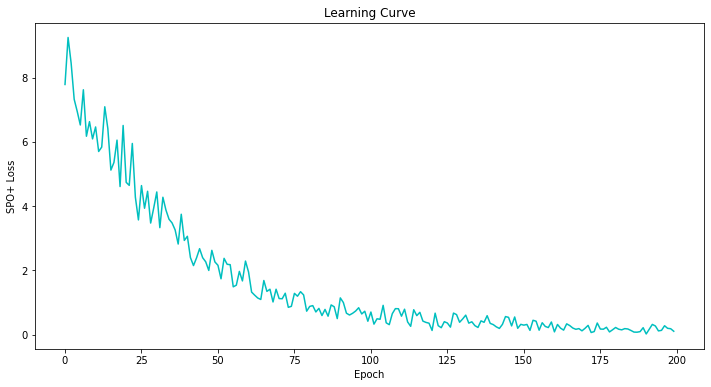

In [23]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()